<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week3/template_resnet_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning on ResNet

Hi, and welcome to your next lab! In this lab, you will learn how to use a pre-trained network for an image classification task.

**GPU** is recomended for this assignment. `Runtime` -> `Change runtime type` -> `GPU`

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to fine-tune a pre-trained ResNet18 for multi-class classification
    - How to preprocess and augment image dataset
    - How to evaluate the model with train/validation/test splits
    - How to visualize the results.

# 0 - Download data

In [1]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/3_conv_nn/resnet_transfer_learning/template.zip')
!unzip -q 'template.zip'

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8d512b3aed0c5d97b306c9650e7dba904cac74ae1a503ffb0cd7d5ac18a7a694
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# 1 - Import packages
Here we will import our regular packages with the addition of [torchvision](https://pytorch.org/vision/stable/index.html), which is a part of the PyTorch framework that implements useful utils for image-related tasks. Also, `torchvision` has popular image datasets, and pre-trained models like `ResNet18`, which we will be using in this lab

In [2]:
import os, shutil
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

%matplotlib inline

## Config

In `Config` class, we will define standard hyperparameters for training. There are also few additional hyperparameters: <br><br>
**Data Preparation**
1. test_fraction - the fraction of the whole dataset that will be used for final evaluation
2. validation_fraction - the fraction of the whole dataset that will be used for validating model performance during training
3. num_workers - the number of CPU cores to use for the data loading process
**Data Transformation**
1. mean - the desired mean across each channel after normalization
2. std - the desired standard deviation across each channel after normalization
3. resize_to - the size of the resized images
4. img_size - the final size of cropped images

**Note:** in our previous labs, we used a mean of $0$ and a standard deviation of $1$ as our normalization parameters. However, in this lab, we will be using a neural network that was trained on [ImageNet](https://image-net.org/). So, we will have to standardize our data to the format of `ImageNet`, in which images have mean of $(0.485, 0.456, 0.406)$, and standard deviation of $(0.229, 0.224, 0.225)$.

In [3]:
# VALIDATION_FIELD[cls] Config

class Config:
    # Training
    seed = 21
    epochs = 30
    learning_rate = 0.001
    num_classes = 6
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Data preparation
    data_root = './Chess'
    test_fraction = 0.2
    validation_fraction = 0.15
    batch_size = 16
    num_workers = 2
    classes = ('Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook')

    # Data transformation
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    resize_to = 256
    img_size = 224

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# 2 - Data Preprocessing and visualizations

For our dataset, we will be using [Chessman Image Dataset](https://www.kaggle.com/niteshfre/chessman-image-dataset) from [Kaggle](https://www.kaggle.com). This dataset contains ~80 - 100 images of each chess piece. Our task will be to classify the chess piece by the image. Let's visualize how many images of each class we have:



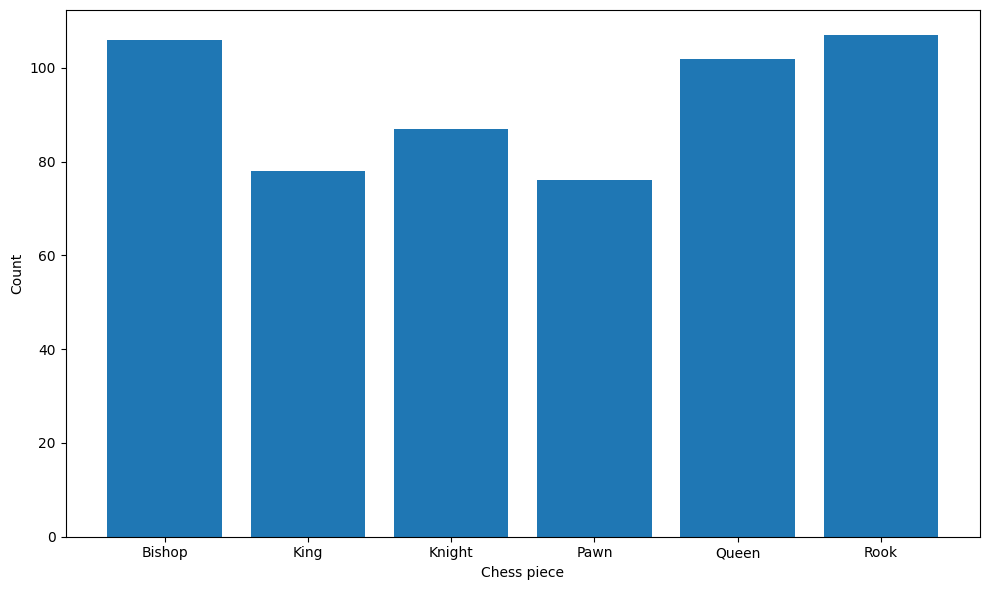

In [5]:
class_counts = {}
for root, dirs, files in os.walk(Config.data_root):
    if root != Config.data_root:
        class_counts[root.split('/')[-1]] = len(files)

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(np.arange(Config.num_classes), Config.classes)
plt.ylabel('Count')
plt.xlabel('Chess piece')
plt.tight_layout()
plt.show()

## Train/Test/Validation split
Here we will split each class of images into `train`, `test`, and `valid` subsets. We will create three directories with respective names and then copy files into those directories. Please note the structure of each folder (it will be important for using `ImageFolder` dataset from `torchvision`):

```
test/
    Bishop/
        00000001.jpg
        00000002.jpg
        ...
   King/
        00000004.jpg
        00000007.jpg
        ...
   Knight/
       ...
   Pawn/
       ...
   Queen/
       ...
   Rook/
       ...
```

In [6]:
def split_data_folder(input_root, train2rest, test2valid):
    # iterate over all classes
    for directory in os.listdir(input_root):
        # skip jupyter and IDE files
        if directory.startswith('.'):
            continue

        # split paths into train, test, and valid
        all_imgs = os.listdir(os.path.join(input_root, directory))
        #print(len(all_imgs))
        train, rest = train_test_split(all_imgs, random_state=Config.seed, test_size=train2rest)
        #print(len(train))
        test, valid  = train_test_split(rest, random_state=Config.seed, test_size=test2valid)

        # copy files into target directories
        data_paths = {'train': train, 'valid': valid, 'test': test}
        for name, subset in data_paths.items():
            for img in subset:
                src = os.path.join(input_root, directory, img)
                dst = os.path.join(name, directory)
                if not os.path.exists(dst):
                    os.makedirs(dst)
                shutil.copy(src, dst)


train2rest = Config.validation_fraction + Config.test_fraction # fraction of data for training
test2valid = Config.validation_fraction/train2rest # fraction of remaining data (validation + test) for testing
split_data_folder(Config.data_root, train2rest, test2valid)

## PyTorch Data Pipeline

PyTorch provides many useful functions and classes to speed up the data preparation and feeding process and decrease RAM usage during training. Here are three main components of the PyTorch Data Pipeline:
1. **Data transforms** - set of functions for data preprocessing and augmentation
2. **PyTorch Dataset** - a base class for PyTorch-like datasets
3. **PyTorch Dataloader** - a class that optimizes the data feeding process and performs batching on a dataset

## Data transforms

**PyTorch transform** is a class that initializes from the transformation parameters like desired resize size or rotation angle for an image and has a method `__call__` that applies the transformation on the input data example.

**Example:** `transforms.Normalize` takes desired `mean` and `std` as inputs and performs image normalization when called.

```python
norm_transform = transforms.Normalize(mean, std)
normalized_img = norm_transform(img)
```

The key feature of data transforms is that you can easily stack them together using `transforms.Compose()`, and pass them to a PyTorch Dataset as a `transform` parameter. So that transforms will be applied every time an image gets extracted from the dataset.
Also, PyTorch uses transform for the **data augmentation** process. So, instead of generating and saving augmented images, PyTorch simply applies a **random** transform on every iteration over the dataset. By doing so, we don't physically increase the size of our dataset but randomly change each image before feeding it into our model.<br><br>
**Excercise:** Using [documentation](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) of transforms, implement `get_transforms` function that returns composed set of transforms for train, validation, and test sets.
**Directions:**
* For `train` set, create the following transforms:
    1. Resize images to `Config.resize_to`
    2. Perform random resized cropping with a size of `Config.img_size`
    3. Perform random horizontal flipping
    4. Convert an image to tensor
    5. Normalize the image to `Config.mean` and `Config.std`
* For `test` and `valid` set create the following:
    1. Resize images to `Config.img_size`
    2. Convert an image to tensor
    3. Normalize the image to `Config.mean` and `Config.std`
   

In [38]:
# VALIDATION_FIELD[func] get_transforms
import torch
import torchvision.transforms as transforms
import PIL
def get_transforms(data_subset):
    """
    Generates composed set of transformations for a given dataset split.

    Arguments:
    data_subset -- string, one of ['train', 'test', 'valid']

    Return:
    transformations -- transforms.Compose, a set of transformations
    """
    if data_subset == 'train':
        transformations = transforms.Compose([
            ### START CODE HERE ### (≈5 lines of code)
                transforms.Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR),
                transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


            ### END CODE HERE ###
            ])
    else:
        ### START CODE HERE ### (≈4 lines of code)
        transformations = transforms.Compose([transforms.Resize(size=(Config.img_size, Config.img_size), interpolation=PIL.Image.BILINEAR),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=Config.mean, std=Config.std)
       ])
        ### END CODE HERE ###
    return transformations

In [39]:
print('Train transforms:', get_transforms('train'))
print('Test transforms:', get_transforms('test'))

Train transforms: Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


**Expected Output: (some default parameters might differ depending on the version of PyTorch)**

```
Train transforms: Compose(
    Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Test transforms: Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
```

## Dataset and Dataloader

Every PyTorch Dataset inherits from a base **Dataset** class, and implements three methods `__init__`, `__len__`, and `__getitem__`. By definition, the dataset doesn't store every example in the memory; instead, it only saves the meta-information, like image path, about how to extract a data sample. Then, the `__getitem__` method extracts the data sample (image in our case) by id. In this lab, we will use `torchvision.ImageFolder` dataset that implements image loading from a folder, and pass our `transforms` as a parameter. In future labs, we will implement our own datasets, so stay tuned! <br><br>
To load images in batches, we use **DataLoader** class that performs batching operation on the given dataset. In our case, we will use `shuffle=True` to shuffle the examples and indicate `num_workers=Config.num_workers` to set the number of CPU cores that would work in parallel on extracting images from the dataset (standard Google Colab has only 2 CPU cores).

In [40]:
dataloaders = {}
for name in ['train', 'valid', 'test']:
    dataset = ImageFolder(name, transform=get_transforms(name))
    dataloaders[name] = DataLoader(dataset, shuffle=True,
                                   batch_size=Config.batch_size,
                                   num_workers=Config.num_workers)

## Show batches of data
Let's visualize images that we feed into our neural network!<br>
For data visualization, we will use the `matplotlib` library.
But if we try to pass the tensor image to `plt.imshow()`,  we will get an error because `matplotlib` is using a different image format. For torch.Tensor — $[C, H, W]$ is used, but for `plt.imshow()` $[H, W, C]$ is required, where: $C$ is the number of channels, $H$ is the height,  and $W$ is the width of an image.

Also, our images are normalized, so we have to renormalize them back using the initial mean and standard deviation to get the original images.
Here is our normalization formula:
$$X_{new}= \frac{X - \mu}{\sigma}$$
So, to get the original image, we have to perform the following:
$$X= X _{new} * \sigma + \mu$$

**Excercise:** Convert image to a displayable format.
To do so, you will have to implement the following:
1. Convert `torch.Tensor` to `np.array`
2. Change $[C, H, W]$ to $[H, W, C]$ format
3. Renormalize the image using `Config.mean` and `Config.std`
4. Clip image to $[0, 1]$ range

In [41]:
# VALIDATION_FIELD[func] tensor_to_array

def tensor_to_array(img, mean = Config.mean, std = Config.std):
    ### START CODE HERE ### (≈4 lines of code)
    # np_img = img.cpu().detach().numpy()
    # np_img = np.transpose(img, (1, 2, 0))
    # np_img = np_img * np.asarray(std) + np.asarray(mean)
    # np_img = np.clip(np_img, 0, 1)
    np_img = img.cpu().detach().numpy()

    # Change [C,H,W] to [H,W,C] format
    np_img = np.transpose(np_img, (1, 2, 0))

    # Renormalize the image using Config.mean and Config.std
    np_img = np_img * std + mean

    # Clip image to [0,1] range
    np_img = np.clip(np_img, 0, 1)

    ### END CODE HERE ###
    return np_img

In [ ]:
img = torch.tensor([[[-0.6254, -1.4061],
                     [-0.0780,  0.3829]],

                    [[ 0.9516,  0.0839],
                     [-0.6721,  0.5566]],

                    [[ 0.8674, -0.5620],
                     [ 0.4436, -1.0338]]])
print('np_img:', tensor_to_array(img))

np_img: [[[0.3417834  0.6691584  0.601165  ]
  [0.16300309 0.4747936  0.27955001]]

 [[0.467138   0.3054496  0.50581   ]
  [0.5726841  0.58067839 0.173395  ]]]


**Expected output:**
    
<table>
    <tr>
        <td><b>np_img</b></td>
        <td>[[[0.3417834  0.6691584  0.601165  ]<br>
              [0.16300309 0.4747936  0.27955001]]<br><br>
             [[0.467138   0.3054496  0.50581   ]<br>
              [0.5726841  0.58067839 0.173395  ]]]
        </td>
    </tr>

</table>

In [42]:
def show_grid(grid, title=None):
    """
    displays a grid of images
    """
    np_grid = tensor_to_array(grid)

    # display
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(np_grid)
    if title is not None:
        plt.title(title)

Now let's use torchvision's utility `make_grid` function to visualize a batch of data from each dataloader.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


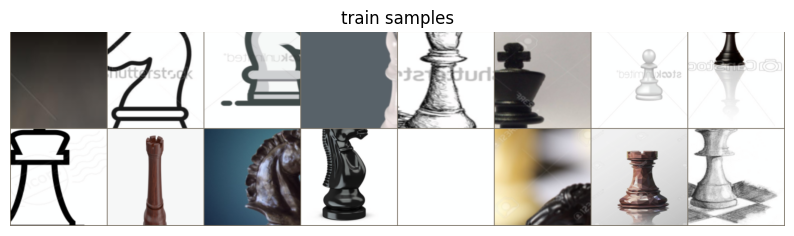

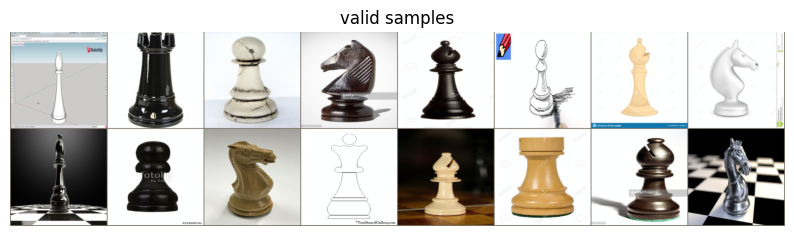

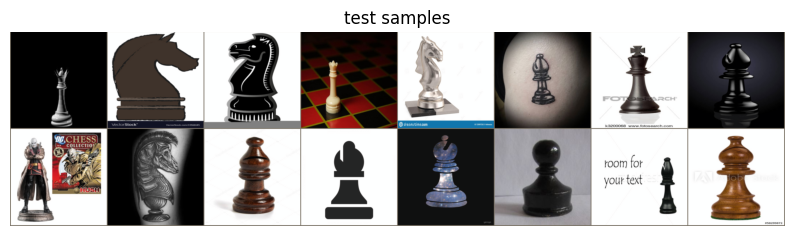

In [43]:
for name in dataloaders.keys():
    imgs, labels = next(dataloaders[name].__iter__())
    out = make_grid(imgs)
    show_grid(out, f'{name} samples')

# 3 - ResNet

ResNet was first proposed in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf). Its revolutionary idea to use residual **skip connections** allowed researchers to build even deeper networks without vanishing gradient problems during training. This advancement allowed to improve the state-of-the-art on image classification. At the same time, residual connections became a new standard in building a deep neural network in domains outside of computer vision.

The original paper proposed several variations of the ResNet with 18, 34, 50, 101, 152 layers, respectively. In ResNet18 model, there were 18 convolutional layers (denoted **3x3** or **7x7**  on the diagram) followed by pooling layers, **pool**, and **ReLU** activation functions. Starting from the second layer, after every two layers, there is a residual skip connection to improve the flow of gradients through the model. The solid residual is a simple addition, while the dotted residuals increase dimensions before adding the inputs. The output layer is a fully connected layer with 1000 output neurons (ImageNet has 1000 classes), which we will replace with our own linear layer with six output neurons (one for each chess piece).


<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/resnet_network.png">

## Creating the model class

Here we define the model class itself. First, we import the model from `torchvision` (using `pretrained=True` to download the weights. Then, we replace the last fully connected layer with our own layer that has `num_classes` outputs. For training a ResNet model, we have two options: we can "freeze" (set `requires_grad` to False) all parameters of a neural network and train only our fully connected layer, or we can train all parameters, which is computationally more expensive but usually gives better results.

In [44]:
# VALIDATION_FIELD[cls] ResNet

class ResNet(nn.Module):
    def __init__(self, freeze=True):
        super(ResNet, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)
        if freeze:
            self.freeze_resnet()
        output_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(output_features, Config.num_classes)

    def freeze_resnet(self):
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.resnet(x)
        return x

# 4 - Training the model

We will make few important modifications to our regular training loop:
1. Callbacker dictionary that saves metrics and losses
2. Dataloaders instead of passing all input data directly to the function.
3. Evaluation loop every epoch to check our model performance on the validation set.
4. Save our model every time validation loss decreases.
5. To count the average loss, we will multiply loss at each iteration by the size of the batch, add it to `train_loss`, and then divide it by a number of examples in a dataset, `len(dataloader.sampler)`

**Excercise:** Implement parts of the train and evaluation loop.

In [45]:
# VALIDATION_FIELD[func] train

def train(model, optimizer, criterion, train_loader, valid_loader,
          num_epochs=Config.epochs, valid_loss_min=np.inf, device=Config.device):
    callbackers = {}
    callbackers['train_loss'] = []
    callbackers['valid_loss'] = []
    callbackers['accuracy'] = []
    callbackers['f1_macro'] = []

    for e in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for imgs, labels in train_loader:
            ### START CODE HERE ###
            # pass the data to the device (≈2 lines of code)
            imgs = imgs.to(device)
            labels = labels.to(device)
            # forward (≈2 lines of code)
            out = model(imgs)
            loss = criterion(out, labels)
            # optimize (≈3 lines of code)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### END CODE HERE ###
            train_loss += loss.item()*imgs.shape[0]
        ######################
        # evaluate the model #
        ######################
        model.eval()
        with torch.no_grad():
            targets, predictions = [], []
            for imgs, labels in valid_loader:
                ### START CODE HERE ### (≈ 6 lines of code)
                imgs = imgs.to(device)
                labels = labels.to(device)
                out = model(imgs)
                loss = criterion(out, labels)
                # convert prediction and targets to numpy
                prediction = torch.argmax(out, dim=1).cpu().numpy()
                target = labels.cpu().numpy()
                ### END CODE HERE ###
                predictions.extend(prediction)
                targets.extend(target)
                valid_loss += loss.item()*imgs.shape[0]

        # calculate metrics
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        acc = accuracy_score(predictions, targets)
        f1_macro = f1_score(predictions, targets, average='macro')

        # print values
        print(f'Epoch: {e+1} TrainLoss: {train_loss:.3f} ValidLoss: {valid_loss:.3f} ACC: {acc:.3f} F1_MACRO: {f1_macro}')

        # save metrics
        callbackers['train_loss'].append(train_loss)
        callbackers['valid_loss'].append(valid_loss)
        callbackers['accuracy'].append(acc)
        callbackers['f1_macro'].append(f1_macro)

        ######################
        #   save the model   #
        ######################
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'ResNet.pt')
            valid_loss_min = valid_loss

    return callbackers

In [46]:
def visualize_callbackers(callbackers):
    fig, ax =  plt.subplots(2, 1, figsize=(10, 6))
    ax[0].plot(callbackers['train_loss'], label='Train Loss')
    ax[0].plot(callbackers['valid_loss'], label='Valid Loss')
    ax[0].set_title('Losses')
    ax[0].legend()
    ax[1].plot(callbackers['accuracy'], label='Accuracy')
    ax[1].plot(callbackers['f1_macro'], label='F1-macro')
    ax[1].set_title('Classification metrics')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

# 5 - Evaluating the model

Let's also implement our regular evaluation loop that will run the model evaluation on the test set <br>
**Excercise:** implement function `evaluate`

**Hints:**
* To effectively compute predictions consider using `torch.argmax`
* Don't forget to call `cpu()` and `numpy()` when appropriate.
* Make sure that targets and predictions in the output of the function is a list of integers

In [47]:
# VALIDATION_FIELD[func] evaluate

def evaluate(model, criterion, test_loader, device=Config.device):
    model.eval()
    with torch.no_grad():
        targets, predictions = [], []
        overall_loss = 0
        for imgs, labels in test_loader:
            ### START CODE HERE ### (≈6 lines of code)
            imgs = imgs.to(device)
            labels = labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            prediction = torch.argmax(out, dim=1).cpu().numpy()
            target = labels.cpu().numpy()
            ### END CODE HERE ###
            targets.extend(target)
            predictions.extend(prediction)
            overall_loss += loss.item()*imgs.shape[0]
        overall_loss /= len(test_loader.sampler)
        accuracy = accuracy_score(targets, predictions)
        f1_macro = f1_score(targets, predictions, average='macro')
        return {'targets': targets,
                'predictions': predictions,
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'loss': overall_loss
                }

In [48]:
def draw_confusion(targets, predictions):
    confusion = confusion_matrix(targets, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, cbar=False,
                xticklabels=Config.classes,
                yticklabels=Config.classes)
    plt.ylabel('Predicted class')
    plt.xlabel('Actual class')
    plt.show()

# 6 - "frozen" vs. full

**Note:** you don't have to wait for the model to finish training to submit the lab. We evaluate your code only in cells where we ask you to implement a funciton or a class.

## Training "frozen" model

Train loss after 30 epochs should be around 0.854.

In [ ]:
set_seed(Config.seed)
model = ResNet(freeze=True).to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
criterion = nn.CrossEntropyLoss()
callbackers = train(model, optimizer, criterion, dataloaders['train'], dataloaders['valid'])
visualize_callbackers(callbackers)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Loss: 0.9277655644850298
Test Accuracy: 0.6727272727272727
Test F1 Macro: 0.6537099599599601


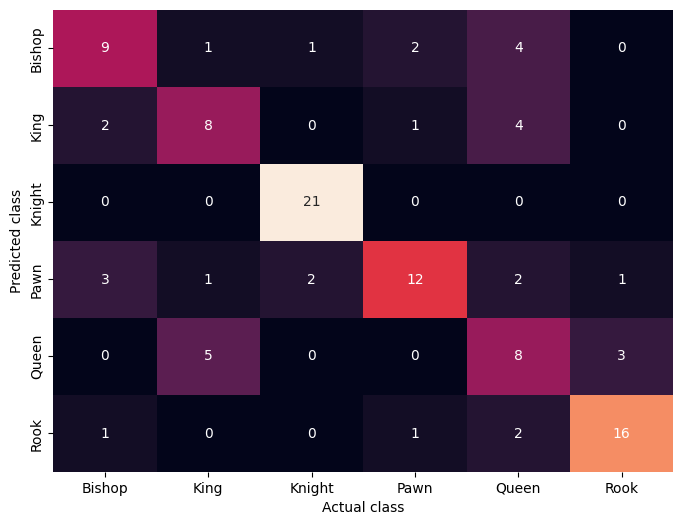

In [ ]:
# Load the best model
model.load_state_dict(torch.load('ResNet.pt'))
results = evaluate(model, criterion, dataloaders['test'])
print('Test Loss:', results['loss'])
print('Test Accuracy:', results['accuracy'])
print('Test F1 Macro:', results['f1_macro'])
draw_confusion(results['targets'], results['predictions'])

**Expected output:**
    
<table>
    <tr>
        <td><b>Test Loss</b></td>
        <td>1.066782832145691
        </td>
    </tr>
    <tr>
        <td><b>Test Accuracy</b></td>
        <td>0.5833333333333334
        </td>
    </tr>
    <tr>
        <td><b>Test F1 Macro</b></td>
        <td>0.5721092524836143
        </td>
    </tr>

</table>

## Training the full model

Training loss after 30 epochs should be around 0.628.

In [ ]:
set_seed(Config.seed)
model = ResNet(freeze=False).to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
callbackers = train(model, optimizer, criterion, dataloaders['train'], dataloaders['valid'], num_epochs=Config.epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 TrainLoss: 1.872 ValidLoss: 11.216 ACC: 0.333 F1_MACRO: 0.21816641525750366


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2 TrainLoss: 1.687 ValidLoss: 2.123 ACC: 0.356 F1_MACRO: 0.27139587930662984


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3 TrainLoss: 1.439 ValidLoss: 1.313 ACC: 0.460 F1_MACRO: 0.38013371235716775


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4 TrainLoss: 1.208 ValidLoss: 2.026 ACC: 0.644 F1_MACRO: 0.6004655067155068


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5 TrainLoss: 1.110 ValidLoss: 0.774 ACC: 0.667 F1_MACRO: 0.6097726325700574


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6 TrainLoss: 0.957 ValidLoss: 0.659 ACC: 0.736 F1_MACRO: 0.7032985608036317


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7 TrainLoss: 0.822 ValidLoss: 1.100 ACC: 0.747 F1_MACRO: 0.7285784792900541


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8 TrainLoss: 0.884 ValidLoss: 2.158 ACC: 0.540 F1_MACRO: 0.5535937545011955


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9 TrainLoss: 1.001 ValidLoss: 0.790 ACC: 0.713 F1_MACRO: 0.704464196473192


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 TrainLoss: 0.854 ValidLoss: 1.154 ACC: 0.632 F1_MACRO: 0.61528721364956


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 TrainLoss: 0.948 ValidLoss: 2.120 ACC: 0.483 F1_MACRO: 0.4557203847526428


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 TrainLoss: 0.797 ValidLoss: 0.673 ACC: 0.736 F1_MACRO: 0.6895074012009496


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 TrainLoss: 0.857 ValidLoss: 0.737 ACC: 0.724 F1_MACRO: 0.7276369168356999


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 TrainLoss: 0.723 ValidLoss: 0.595 ACC: 0.793 F1_MACRO: 0.76837913103157


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 15 TrainLoss: 0.798 ValidLoss: 0.811 ACC: 0.747 F1_MACRO: 0.6978407557354926


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 16 TrainLoss: 0.816 ValidLoss: 2.148 ACC: 0.529 F1_MACRO: 0.47993336484715793


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 17 TrainLoss: 0.831 ValidLoss: 0.879 ACC: 0.701 F1_MACRO: 0.6983641139823935


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 18 TrainLoss: 0.820 ValidLoss: 0.601 ACC: 0.816 F1_MACRO: 0.7815852018638397


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 19 TrainLoss: 0.624 ValidLoss: 0.548 ACC: 0.816 F1_MACRO: 0.7996121933621932


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 20 TrainLoss: 0.654 ValidLoss: 0.738 ACC: 0.770 F1_MACRO: 0.7323176643029584


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 21 TrainLoss: 0.669 ValidLoss: 0.569 ACC: 0.782 F1_MACRO: 0.7547778731989259


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 22 TrainLoss: 0.563 ValidLoss: 0.376 ACC: 0.897 F1_MACRO: 0.8914123918350838


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 23 TrainLoss: 0.617 ValidLoss: 0.595 ACC: 0.793 F1_MACRO: 0.7820553359683795


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 24 TrainLoss: 0.661 ValidLoss: 0.714 ACC: 0.793 F1_MACRO: 0.7974123594484146


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 25 TrainLoss: 0.673 ValidLoss: 0.871 ACC: 0.770 F1_MACRO: 0.764666412394607


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 26 TrainLoss: 0.581 ValidLoss: 0.542 ACC: 0.839 F1_MACRO: 0.8219392666761087


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 27 TrainLoss: 0.682 ValidLoss: 1.319 ACC: 0.632 F1_MACRO: 0.5582604529972951


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 28 TrainLoss: 0.707 ValidLoss: 0.534 ACC: 0.839 F1_MACRO: 0.8255345203215385


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 29 TrainLoss: 0.670 ValidLoss: 0.774 ACC: 0.759 F1_MACRO: 0.7485473892698847


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 30 TrainLoss: 0.685 ValidLoss: 0.799 ACC: 0.793 F1_MACRO: 0.7872838819538858


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Loss: 0.4746437441218983
Test Accuracy: 0.8545454545454545
Test F1 Macro: 0.8426484368344833


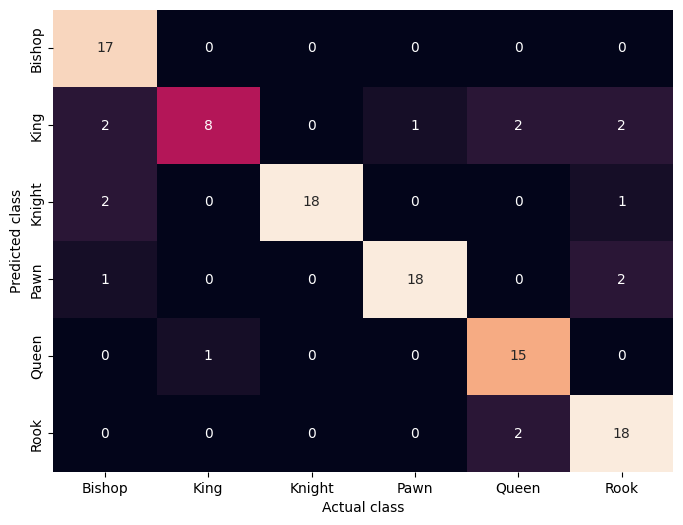

In [ ]:
# Load the best model
model.load_state_dict(torch.load('ResNet.pt'))
results = evaluate(model, criterion, dataloaders['test'])
print('Test Loss:', results['loss'])
print('Test Accuracy:', results['accuracy'])
print('Test F1 Macro:', results['f1_macro'])
draw_confusion(results['targets'], results['predictions'])

**Expected output:**
    
<table>
    <tr>
        <td><b>Test Loss</b></td>
        <td>0.5063939381528784
        </td>
    </tr>
    <tr>
        <td><b>Test Accuracy</b></td>
        <td>0.8703703703703703
        </td>
    </tr>
    <tr>
        <td><b>Test F1 Macro</b></td>
        <td>0.8524070691111768
        </td>
    </tr>

</table>

**Interpretation:** not surprisingly, training a full model gave us a better accuracy than freezing a part of it. This is because training all parameters allows the model to learn task-specific features, including some specific edges of chess pieces in our case. Whereas training a "frozen" network, we only create a linear mapping from some features that ResNet learned on ImageNet to classes of our chess pieces, which might be not as effective but computationally faster.

# 6 - What to do next

1. Submit your lab to `@DRU bot`. Don't worry if your accuracy is not that high; you don't have to wait for the model to finish training to submit the lab.  <br>
2. After you submit your lab, try playing with model architecture and hyperparameters. Add metrics to callbackers and see how they change during the training process. Experiment with the loss scaling method, just like we did in the Multi-Class Classification problem in the previous module.